In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
# Import trades database

# Enter your CSV with only the column of results in points. 
# Note that the name of the column must be "points".

# df = pd.read_csv('Backtest Estratégias - DTB - Sample.csv')
df = pd.read_csv('Backtest Estratégias - LRI - Sample.csv')


df.head()

,Data,Description,Unnamed: 2,Unnamed: 3,Unnamed: 4,Time,Result,N,Soma
0,28/05/20,[Trade 1 - LRI - C@87.110] E: Contexto lateral...,NaN,NaN,NaN,G,195.0,"0,75",195
1,29/05/20,"[Trade 1 - LRI - C@86640] E: Contexto lateral,...",NaN,NaN,NaN,G,180.0,"0,75",375
2,02/06/20,[Trade 1 - LRI < 10h - V@89.660] E: Contexto l...,NaN,NaN,NaN,L,-10.0,0,365
3,04/06/20,[Trade 1 - LRI > 14h - C@93.100] E: Contexto l...,NaN,NaN,NaN,L,25.0,"-0,15",390
4,17/06/20,"[Conta Real] [Trade - LRI - C@94.480 -0,3N] S:...",NaN,NaN,NaN,L,-60.0,"-0,3",330


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Data         69 non-null     object 
 1   Description  69 non-null     object 
 2   Unnamed: 2   0 non-null      float64
 3   Unnamed: 3   0 non-null      float64
 4   Unnamed: 4   0 non-null      float64
 5   Time         69 non-null     object 
 6   Result       69 non-null     float64
 7   N            69 non-null     object 
 8   Soma         71 non-null     int64  
dtypes: float64(4), int64(1), object(4)
memory usage: 5.1+ KB


In [32]:
# Make a Clean Copy of the Original Dataframe
df_clean = df.copy()

# Drop unused columns 
df_clean.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Time'], axis=1, inplace=True)


# Convert Date 
#df_clean['Data'] = pd.to_datetime(df['Data'], format='%Y-%m-%d %H:%M:%S.%f')

In [58]:
# Select positive and negative trades percentage

pos_perc = df_clean.query("Result > 0").count()/df.shape[0]
neg_perc = df_clean.query("Result < 0 or Result == 0").count()/df.shape[0]

print('Porcentagem Positivos', pos_perc, 'Porcentagem Negativos:', neg_perc)

Porcentagem Positivos 0.38028169014084506 Porcentagem Negativos: Data           0.591549
Description    0.591549
Result         0.591549
N              0.591549
Soma           0.591549
dtype: float64


### Fixing Null N Values

We use the negative trades as the base to set the N value. This value will be used in both positive and negative trades, following System Quality Number rule from Van K Tharp.


In [34]:
negative_trades = df_clean.query('Result < 0 or Result == 0')
 
n_value = negative_trades['Result'].sum()/negative_trades.shape[0]

n_value.round(0)


-48.0

In [29]:
def set_null_nvalues(x):
    
    if x < 0 or x == 0:
        if x != 'NaN':
            return -(x / n_value)
    else:
        if x != 'NaN':
            return (x / -n_value)
    
df_clean['N'] = df_clean['Result'].map(set_null_nvalues)

df_clean.sample(10)

,Data,Description,Result,N,Soma
52,18/09/19,[Trade 1 - LRI - C@106.545] E: Contexto latera...,-90.0,-1.885287,1485
10,06/02/20,[Trade - LRI Merge - V@117.350] S: Fechando 20...,-20.0,-0.418953,345
1,29/05/20,"[Trade 1 - LRI - C@86640] E: Contexto lateral,...",180.0,3.770574,375
21,05/02/19,[Trade 1 - LRI - C@101.410] E: Contexto latera...,90.0,1.885287,885
6,19/06/20,[Trade - LRI - C@97.120 [original 97.060] 0N] ...,0.0,0.000000,230
35,15/05/19,[Trade 1 - LRI - V@93.035] E: Contexto lateral...,115.0,2.408978,1580
64,29/11/19,"[Trade - LRI - C@108.910] E: Contexto lateral,...",-75.0,-1.571072,1505
57,30/09/19,"[Trade - LRI - C@106.615] E: Contexto lateral,...",-30.0,-0.628429,1415
54,19/09/19,"[Trade - LRI - V@107.740] E: Contexto lateral,...",90.0,1.885287,1555
65,15/02/18,"[Trade - LRI - V@92.210] E: Contexto lateral, ...",-15.0,-0.314214,1490


In [51]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Data         69 non-null     object 
 1   Description  69 non-null     object 
 2   Result       69 non-null     float64
 3   N            69 non-null     float64
 4   Soma         71 non-null     int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 2.9+ KB


In [68]:
df_clean['Result'].describe()

count     69.000000
mean      23.550725
std      102.337035
min     -230.000000
25%      -50.000000
50%        0.000000
75%      115.000000
max      265.000000
Name: Result, dtype: float64

### Metrics

In [12]:
# Sharpe index

df_clean['Result'].mean()/df_clean['Result'].std()


0.23012905015318688

In [13]:
# Profit factor 

pos = df_clean.query("Result > 0")
neg = df_clean.query("Result < 0 or Result == 0")

pos['Result'].sum()/-(neg['Result'].sum())


1.8104738154613467

In [14]:
# Risk Reward 

rr = pos['Result'].mean()/-neg['Result'].mean()

rr

2.8162926018287617

In [15]:
# Minimum Risk Reward 

w = df_clean.query("Result > 0").count()/df_clean.shape[0]
w = pd.to_numeric(w)

(1 - w)/w

Data           1.62963
Description    1.62963
Result         1.62963
N              1.62963
Soma           1.62963
dtype: float64

In [16]:
# Mathematical Expectation

In [17]:
# Expected Reward

In [84]:
# Edge

edge = w - (1/(1+rr))
edge

Data           0.118247
Description    0.118247
Result         0.118247
N              0.118247
Soma           0.118247
dtype: float64

In [19]:
# Kelly 

w - (1-w)/rr

Data           0.160234
Description    0.160234
Result         0.160234
N              0.160234
Soma           0.160234
dtype: float64

### System Quality Number

In [20]:
# SQN 

import math

r = (negative_trades.loc[:, "Result"].mean())

expectancy = (df_clean.loc[:, "Result"] / (-r)).mean()

r_multiple = (df_clean.loc[:, "Result"] / (-r))

standard_deviation = r_multiple.std()

square_root_num_trades = math.sqrt(len(df_clean))

sqn = round(((expectancy/standard_deviation)*square_root_num_trades), 3)

sqn

1.939

### Ruin Risk

##### Simple Way

In [80]:
# Negative Trades Mean 

negative_trades = df_clean.query('Result < 0 or Result == 0')
 
n_value = negative_trades['Result'].sum()/negative_trades.shape[0]

n_value.round(0)

# Convert to $ 

number_contracts = 1

n_value = n_value*(number_contracts*0.2)
n_value

-9.54761904761905

In [90]:
# Total loss sequence in $ to reach 30% of total capital loss. 

total_capital = 1000

# Risk per trade in $
risk_per_trade = 40

u = (total_capital*0.3)/risk_per_trade

u

#ruin_risk = ((1-edge)/(1+edge))^u

7.5

### Visualizations

In [21]:
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

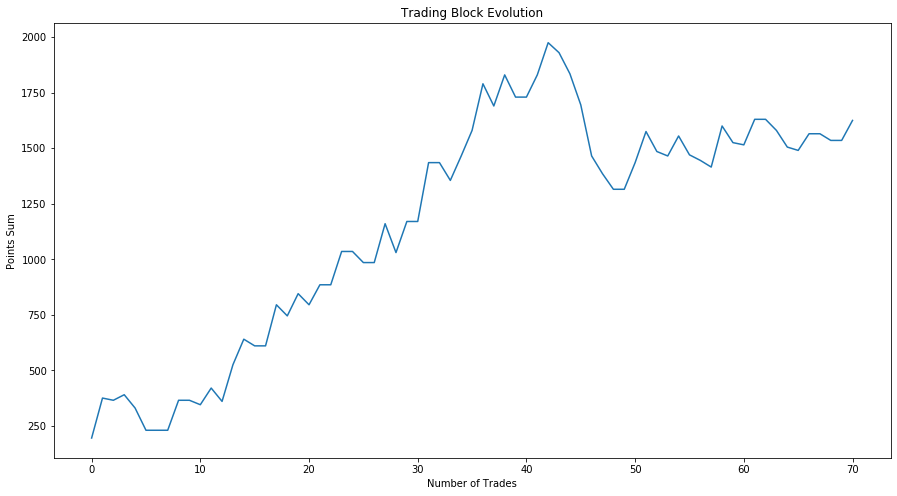

In [22]:
# Trading Block Evolution 

binsize = 10
bins = np.arange(0, df['Soma'].max()+binsize, binsize)

def graph():
    plt.plot(df.index, df['Soma'])
    
plt.figure(figsize=[15,8])    
plt.title('Trading Block Evolution')  
plt.ylabel('Points Sum')
plt.xlabel('Number of Trades')

plt.show(graph());

In [52]:
# Replace , with . and, set as float column N 

df_clean['N'] = df_clean['N'].str.replace(',','.')
df_clean['N'] = df_clean['N'].astype(float)

df_clean.sample(5)

,Data,Description,Result,N,Soma
3,04/06/20,[Trade 1 - LRI > 14h - C@93.100] E: Contexto l...,25.0,-0.15,390
65,15/02/18,"[Trade - LRI - V@92.210] E: Contexto lateral, ...",-15.0,-0.10,1490
58,03/10/19,"[Trade - LRI - C@102.375] E: Contexto lateral,...",185.0,1.00,1600
57,30/09/19,"[Trade - LRI - C@106.615] E: Contexto lateral,...",-30.0,-0.20,1415
18,10/01/19,[Trade 1 - LRI - V@96.810] E: Contexto lateral...,-50.0,-0.50,745


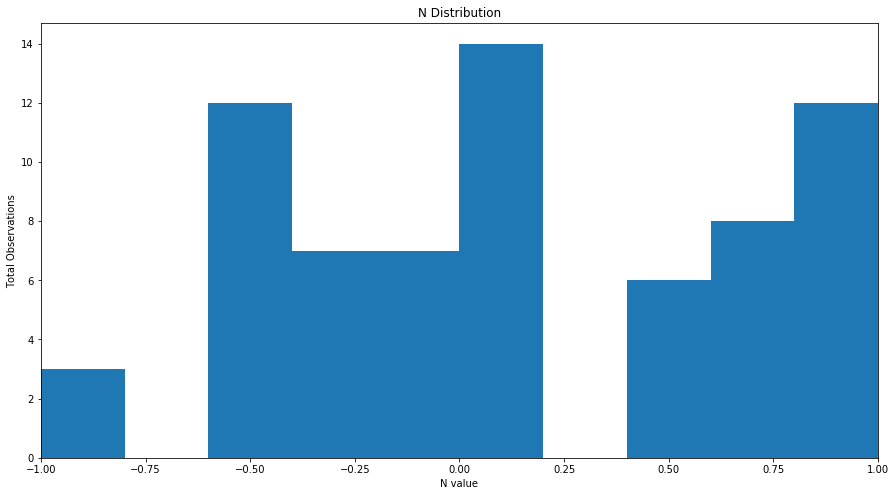

In [57]:
# Trades N distribution

binsize = 0.05
bins = np.arange(0, df_clean['N'].max()+binsize, binsize)

def graph():
    plt.hist(df_clean['N'])
    #plt.hist(data = df_clean, alpha=0.8, facecolor='y', x = 'N', bins = bins)
    
plt.figure(figsize=[15,8])    
plt.title('N Distribution')  
plt.ylabel('Total Observations')
plt.xlabel('N value')
plt.xlim([-1, 1])

plt.show(graph());